In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os as os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

C:\Users\Harsh jaglan\AppData\Local\Temp\ipykernel_13072\2549411833.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
image_dir = "flowers"
filepaths = []
labels = []

for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        # Get all image files within the folder
        for filename in os.listdir(folder_path):
            if filename.endswith((".jpg", ".jpeg", ".png")):
                filepath = os.path.join(folder_path, filename)
                filepaths.append(filepath)
                labels.append(folder)
    
# Convert data into pandas DataFrames
filepaths_df = pd.Series(filepaths, name='Filepath')
labels_df = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths_df, labels_df], axis=1)

# Display the DataFrame (optional)
print(image_df.head())

                                     Filepath  Label
0    flowers\daisy\100080576_f52e8ee070_n.jpg  daisy
1    flowers\daisy\10140303196_b88d3d6cec.jpg  daisy
2  flowers\daisy\10172379554_b296050f82_n.jpg  daisy
3    flowers\daisy\10172567486_2748826a8b.jpg  daisy
4  flowers\daisy\10172636503_21bededa75_n.jpg  daisy


In [3]:
#Display Tail of the data
image_df.tail()

,Filepath,Label
4312,flowers\tulip\9831362123_5aac525a99_n.jpg,tulip
4313,flowers\tulip\9870557734_88eb3b9e3b_n.jpg,tulip
4314,flowers\tulip\9947374414_fdf1d0861c_n.jpg,tulip
4315,flowers\tulip\9947385346_3a8cacea02_n.jpg,tulip
4316,flowers\tulip\9976515506_d496c5e72c.jpg,tulip


In [4]:
#Let's Shuffle the Data of Flowers.
import random

image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,flowers\tulip\133960364_d87f883c15_n.jpg,tulip
1,flowers\tulip\17012955700_7141d29eee.jpg,tulip
2,flowers\tulip\6770436217_281da51e49_n.jpg,tulip
3,flowers\rose\20851336110_b17107948d_n.jpg,rose
4,flowers\sunflower\14698136411_23bdcff7bf_n.jpg,sunflower


In [5]:
#shape of the Dataset

In [6]:
image_df.shape

(4317, 2)

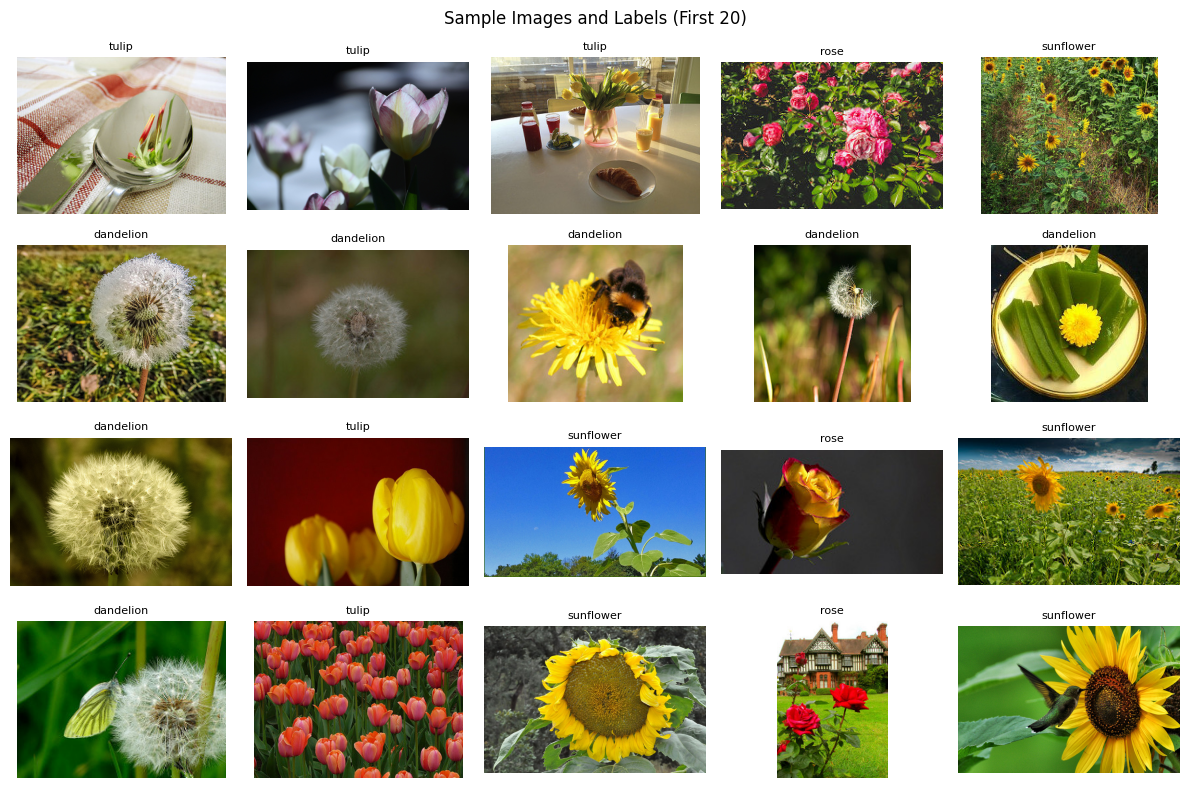

In [7]:
# Display 20 picture of the dataset with their labels

# Define the number of images to display (adjust as needed)
num_images_to_display = 20
image_df_subset = image_df.head(num_images_to_display)

# Create a figure for displaying the images
# Create a figure for displaying the images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))  # Adjust rows and columns as needed

# Iterate through the DataFrame subset and display images with labels
for i, row in image_df_subset.iterrows():
    image_path = row['Filepath']
    label = row['Label']

    # Load the image using an appropriate library (adjust based on your image format)
    img = plt.imread(image_path)  # Replace with your image loading method

    # Display the image and label on the corresponding subplot
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(label, fontsize=8)
    axes[i // 5, i % 5].axis('off')  # Hide axes for cleaner visualization

# Adjust layout 
fig.suptitle(f"Sample Images and Labels (First {num_images_to_display})", fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

In [8]:
# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=42)

# Print the shapes of the training and testing sets
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

Training data shape: (3453, 2)
Testing data shape: (864, 2)


In [9]:
#Train Data Shape
print("Training data shape:", train_df.shape)


Training data shape: (3453, 2)


In [10]:
# 3.3 MobilenetV2
# This snippet prepares tools for loading images, preprocessing them in a way that's optimized for training with the MobileNet V2 model,
# and divides the training images into two parts: 80% for training and 20% for validation. The testing images are also preprocessed using
# the same method but are not split.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
#Train Data head and tail
train_df.head()

,Filepath,Label
279,flowers\dandelion\11775820493_10fedf4bff_n.jpg,dandelion
3435,flowers\dandelion\3530500952_9f94fb8b9c_m.jpg,dandelion
3523,flowers\rose\4575042086_7674b76297_n.jpg,rose
1864,flowers\rose\5073473370_bdbb5a99fc.jpg,rose
2028,flowers\daisy\2346726545_2ebce2b2a6.jpg,daisy


In [12]:
train_df.tail()

,Filepath,Label
3444,flowers\dandelion\13560152823_9da5e48c87_m.jpg,dandelion
466,flowers\rose\568715474_bdb64ccc32.jpg,rose
3092,flowers\tulip\14097328354_4f1469a170.jpg,tulip
3772,flowers\tulip\2374855021_21959b40c0_n.jpg,tulip
860,flowers\rose\3997609936_8db20b7141_n.jpg,rose


In [13]:
#Train,validation and test Data Shape
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2763 validated image filenames belonging to 5 classes.
Found 690 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


In [14]:
#Creating Model
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(5, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

In [15]:
#compiles your created CNN model for training
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [16]:
#Callbacks
checkpoint_path = 'models/EfficientNetB1/model_224.keras'  # Using .h5 for TensorFlow 2.3.0+

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=False)
]

In [17]:
#Fit Model
import time

start_time = time.time()
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.8973 - accuracy: 0.7377 - loss: 0.7177
Epoch 1: saving model to models/EfficientNetB1/model_224.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - AUC: 0.8978 - accuracy: 0.7386 - loss: 0.7154 - val_AUC: 0.5010 - val_accuracy: 0.2116 - val_loss: 2.7980 - learning_rate: 0.0010
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.9808 - accuracy: 0.9187 - loss: 0.2256
Epoch 2: saving model to models/EfficientNetB1/model_224.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - AUC: 0.9808 - accuracy: 0.9186 - loss: 0.2259 - val_AUC: 0.5621 - val_accuracy: 0.2565 - val_loss: 2.2931 - learning_rate: 0.0010
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9844 - accuracy: 0.9419 - loss: 0.1762
Epoch 3: saving model to models/EfficientNetB1/model_224.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - AUC: 0.9843 - accuracy: 0.9418 - loss: 0.1766 - val_AUC: 0.5893 - val_accuracy: 0.3000 - val_loss: 2.4577 - learning_rate: 0.0010
Epoc

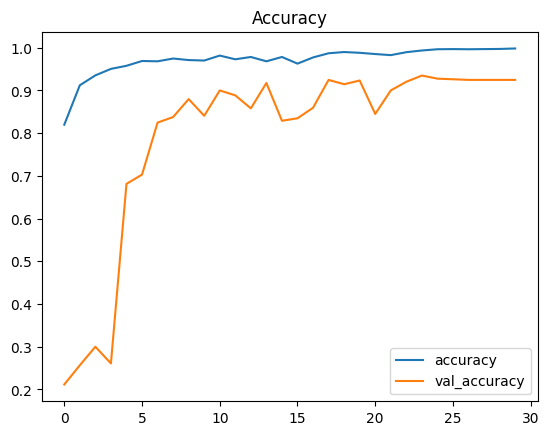

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

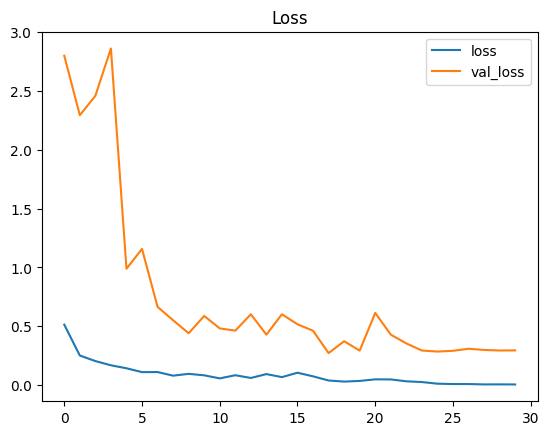

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [20]:
#Evaluate Model
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.31020
Test Accuracy: 98.58%


In [21]:
#Step 5: Prediction
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 564ms/step
The first 5 predictions: ['rose', 'daisy', 'dandelion', 'tulip', 'rose']


In [24]:
#5.1 Classification Report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.93      0.90      0.91       173
   dandelion       0.96      0.96      0.96       228
        rose       0.88      0.89      0.89       149
   sunflower       0.91      0.97      0.94       143
       tulip       0.90      0.89      0.90       171

    accuracy                           0.92       864
   macro avg       0.92      0.92      0.92       864
weighted avg       0.92      0.92      0.92       864



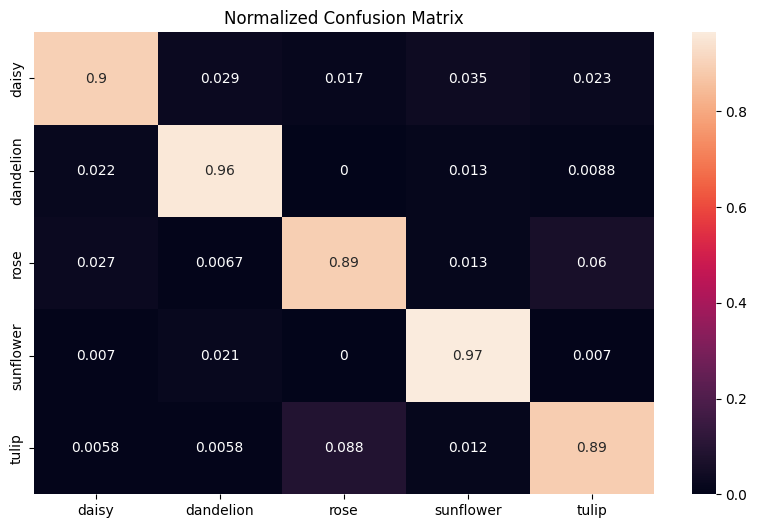

In [25]:
#5.2 Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()


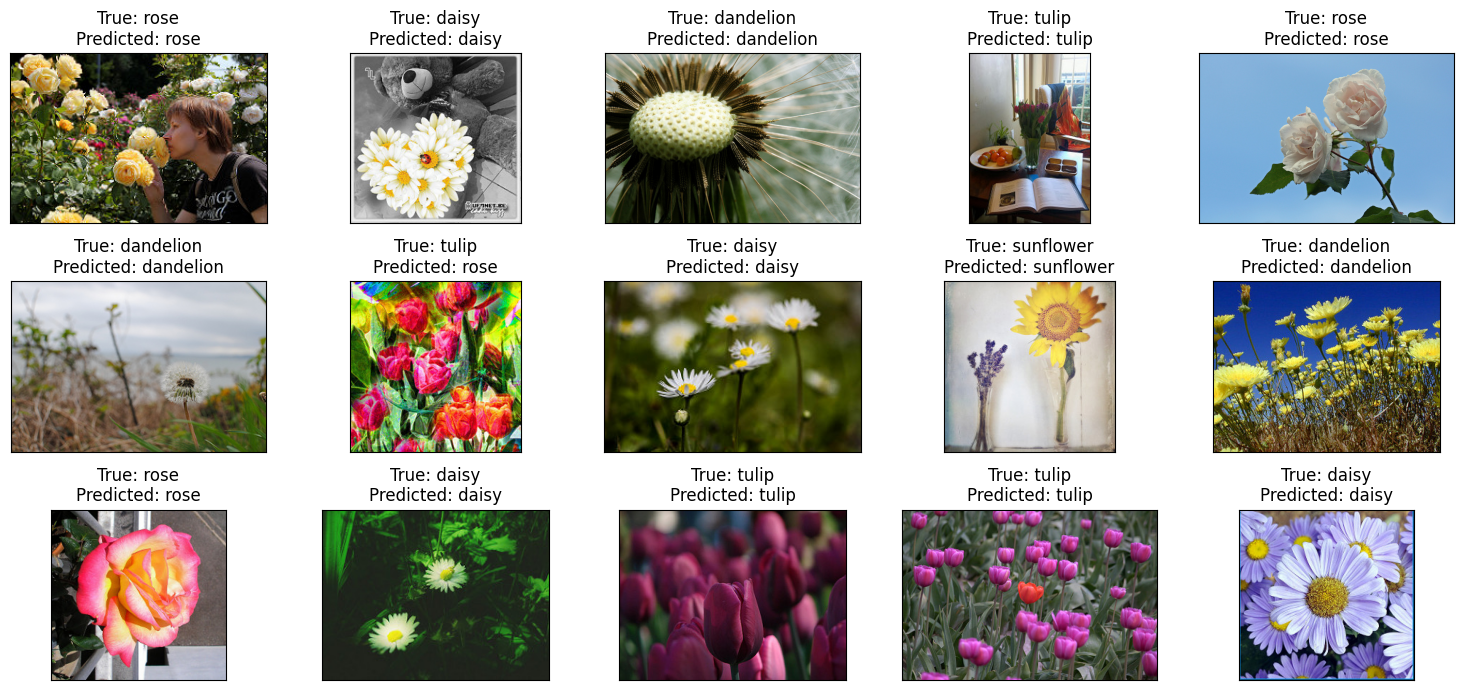

In [26]:
#Vizualize Prediction
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()